# Preprocessing Training Data

In [1]:
import pandas as pd
import numpy as np
from time import process_time 
import pickle
import random

In [2]:
t1=process_time()

### Step 1: Read dataframe, normalise and merge them

In [3]:
data_location=r"D:\Siddharth Data\PLAsTiCC\Raw Data"

In [4]:
df=pd.read_csv(fr"{data_location}\training_set.csv")
df_metadata=pd.read_csv(fr"{data_location}\training_set_metadata.csv")

In [5]:
#Comment and uncomment as required

# all_flux=df.loc[:,"flux"].values
# all_flux_err=df.loc[:,"flux_err"].values

# all_hostgal_specz=df_metadata.loc[:,"hostgal_specz"].values
# all_hostgal_photoz=df_metadata.loc[:,"hostgal_photoz"].values
# all_hostgal_photoz_err=df_metadata.loc[:,"hostgal_photoz_err"].values

In [6]:
#Comment and uncomment as required

# flux_mean=np.mean(all_flux)
# flux_err_mean=np.mean(all_flux_err)
# flux_std=np.std(all_flux)
# flux_err_std=np.std(all_flux_err)

# hostgal_specz_mean=np.mean(all_hostgal_specz)
# hostgal_photoz_mean=np.mean(all_hostgal_photoz)
# hostgal_photoz_err_mean=np.mean(all_hostgal_photoz_err)
# hostgal_specz_std=np.std(all_hostgal_specz)
# hostgal_photoz_std=np.std(all_hostgal_photoz)
# hostgal_photoz_err_std=np.std(all_hostgal_photoz_err)


In [7]:
#Comment and uncomment as required

# df.loc[:,"flux"]=(all_flux - flux_mean)/flux_std
# df.loc[:,"flux_err"]=(all_flux_err - flux_err_mean)/flux_err_std

# df_metadata.loc[:,"hostgal_specz"]=(all_hostgal_specz - hostgal_specz_mean)/hostgal_specz_std
# df_metadata.loc[:,"hostgal_photoz"]=(all_hostgal_photoz - hostgal_photoz_mean)/hostgal_photoz_std
# df_metadata.loc[:,"hostgal_photoz_err"]=(all_hostgal_photoz_err - hostgal_photoz_err_mean)/hostgal_photoz_err_std

In [8]:
df=df.merge(df_metadata)

In [9]:
del(df_metadata)

#Comment and uncomment as required

# del(all_flux)
# del(all_flux_err)
# del(all_hostgal_specz)
# del(all_hostgal_photoz)
# del(all_hostgal_photoz_err)

### Step 2: Compute (cumulative) time difference between each observation for each object

In [10]:
#Calculate time diff between all observations in mjd
df["mjd_diff"]=df['mjd'].diff()
df["mjd_diff"]=df["mjd_diff"].fillna(0)

In [11]:
#Find indexes where new objects appear, and set the mjd_diff for this to 0
obj_change_index=np.where(df["object_id"].values[:-1] != df["object_id"].values[1:])[0] + 1
df.loc[obj_change_index, ['mjd_diff']]=0

In [12]:
# Use groupby method to find seperate cumsums for all objects
df["cumulative_mjd_diff"]=df.loc[:,["object_id", "mjd_diff"]].groupby("object_id").cumsum()

### Step 3: Convert given targets to standard form (0-14) 

In [13]:
#Use dictionary to create new column, replacing targets(6,15,...) by class(0,1,...)
target_dict ={
    6: 0,
    15: 1,
    16: 2,
    42: 3,
    52: 4,
    53: 5,
    62: 6,
    64: 7,
    65: 8,
    67: 9,
    88: 10,
    90: 11,
    92: 12,
    95: 13,
    99: 14
}
df["target_class"]=df.loc[:,["target"]].replace(target_dict)

### Step 4: Group MJDs within 1 night of each other

In [14]:
mjd_arr=df["mjd"].values
time_diff_arr=df["mjd_diff"].values
grouped_mjd_arr=np.zeros_like(mjd_arr)

In [15]:
prev_time=0
for i in range(len(mjd_arr)):
    current_time=mjd_arr[i]
    time_diff=time_diff_arr[i]
    if time_diff==0 or current_time-prev_time>0.33:
        grouped_mjd_arr[i]=current_time
        prev_time=current_time
    else:
        grouped_mjd_arr[i]=prev_time

In [16]:
df["grouped_mjd"]=grouped_mjd_arr

In [17]:
del(grouped_mjd_arr)
del(time_diff_arr)
del(mjd_arr)

### Step 5: For observations of the same passband within 1 night of each other, choose the one with least flux_err

In [18]:
df = df.sort_values("flux_err").groupby(["object_id", "grouped_mjd", "passband"]).first()
df = df.reset_index()

### Step 6: Create passband column

In [19]:
#Drop all unnecessary columns. Note : mjd_diff and cumulative_mjd_diff are dropped as cause problems when pivoting. Will recalculate later
df = df.drop(
    [
        "mjd",
        "detected",
        "ra",
        "decl",
        "gal_b",
        "gal_l",
        "mjd_diff",
        "cumulative_mjd_diff",
#         "ddf",                      #Experiment with these last 3
#         "distmod",
#         "mwebv"
    ],
    axis=1,
)

In [20]:
fixed_features=["ddf","hostgal_specz","hostgal_photoz","hostgal_photoz_err","distmod","mwebv"]
mini_df=df[["object_id"] + fixed_features ].groupby("object_id").first()

df=df.drop(mini_df,axis=1)
df = pd.pivot_table(df, index=["object_id","grouped_mjd","target","target_class"], columns=["passband"])
df.columns= [f"{tup[0]}_passband_{tup[1]}" for tup in df.columns.values]
df=df.reset_index(["grouped_mjd","target","target_class"])
df=df.join(mini_df,how="left")

del(mini_df)

In [21]:
df=df.rename(columns={"grouped_mjd": "mjd"})
df=df.reset_index()


#Calculate time diff between all observations in mjd
df["mjd_diff"]=df['mjd'].diff()
df["mjd_diff"]=df["mjd_diff"].fillna(0)
#Find indexes where new objects appear, and set the mjd_diff for this to 0
obj_change_index=np.where(df["object_id"].values[:-1] != df["object_id"].values[1:])[0] + 1
df.loc[obj_change_index, ['mjd_diff']]=0

In [22]:
#FUTURE: Try making the time series uniform everywhere by inputting 0 everyday when data wasn't measured

### Step 7: Convert dataframe into list of form [(nparray,target_class,obj_id)]

In [23]:
df=df.set_index(["object_id"])

In [24]:
df=df.drop(
    [
        "mjd",
        "target",
    ],
    axis=1,
)
df = df.fillna(0)
#FUTURE: Try filling -1 and see if performance improves

In [25]:
#Save some memory by converting float64 to float32 as 32 enough
for col in df.columns:
    if df[col].dtype == np.float64:
        df[col] = df[col].astype(np.float32)

In [26]:
#Recalculate time diff between all rows and set new objs to zero as before
all_obj_ids=np.unique(df.index.get_level_values(0).values)
dfarray=df.reset_index().to_numpy()
all_obj_ids_long=dfarray[0:,0]
all_labels_long=dfarray[0:,1]
obj_change_index=np.where(all_obj_ids_long[:-1] != all_obj_ids_long[1:])[0] + 1

In [27]:
tuplist=list(zip(np.insert(obj_change_index,0,0),obj_change_index))
list_of_data_arrays=[]
for tup in tuplist:
    list_of_data_arrays.append((dfarray[tup[0]:tup[1],2:],int(dfarray[tup[0],1]),int(dfarray[tup[0],0])))
list_of_data_arrays.append((dfarray[obj_change_index[-1]:,2:],int(dfarray[obj_change_index[-1],1]),int(dfarray[obj_change_index[-1],0])))

In [28]:
#list_of_data_arrays              #REQUIRED LIST OF ARRAYS!!!

In [29]:
del(all_labels_long)
del(all_obj_ids)
del(all_obj_ids_long)
del(df)
del(dfarray)
del(obj_change_index)
del(tuplist)

In [30]:
t2=process_time()
print(f"Preprocessing took {t2-t1} seconds.")

Preprocessing took 10.15625 seconds.


### Step 8: Save as pickle

In [31]:
with open(r"C:\Users\Sid\Desktop\bigpickle", "wb") as fp:   #Pickling
    pickle.dump(list_of_data_arrays, fp)

# Deep Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Bidirectional,Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.backend import clear_session
from keras.optimizers import Adam
import numpy as np
import pickle
import random
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(21)

Using TensorFlow backend.


In [2]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
#     loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
#     print(f'Test loss: {loss:.3}')
#     print(f'Test accuracy: {accuracy:.3}')

In [3]:
try:
    list_of_data_arrays
except NameError:
    with open(r"C:\Users\Sid\Desktop\bigpickle", "rb") as fp:   # Unpickling
        list_of_data_arrays=pickle.load(fp)    

In [4]:
#shuffle=random.sample(list_of_data_arrays, len(list_of_data_arrays))
shuffle=list_of_data_arrays
random.shuffle(shuffle)
del(list_of_data_arrays)

In [5]:
shuffle_arr=np.array(shuffle)[0:,0]
shuffle_labels=np.array(shuffle)[0:,1]
shuffle_obj_ids=np.array(shuffle)[0:,2]
del(shuffle)

In [6]:
max_length=max(map(len,shuffle_arr))

x_train = sequence.pad_sequences(shuffle_arr[:7066], maxlen=max_length)
x_val = sequence.pad_sequences(shuffle_arr[7066:], maxlen=max_length)
y_train=to_categorical(shuffle_labels[:7066], num_classes=15)
y_val=to_categorical(shuffle_labels[7066:], num_classes=15)

clear_session()

data_dim = 19
timesteps = max_length
num_classes = 15

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(64))  # return a single vector of dimension 32
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 162, 64)           21504     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                975       
Total params: 55,503
Trainable params: 55,503
Non-trainable params: 0
_________________________________________________________________


In [7]:
history=model.fit(x_train, y_train,
          batch_size=128, epochs=3,
          validation_data=(x_val, y_val))

Train on 7066 samples, validate on 782 samples
Epoch 1/3
7066/7066 [==============================] - 21s 3ms/step - loss: 1.8151 - accuracy: 0.4366 - val_loss: 1.4358 - val_accuracy: 0.5345
Epoch 2/3
7066/7066 [==============================] - 20s 3ms/step - loss: 1.3336 - accuracy: 0.5536 - val_loss: 1.2010 - val_accuracy: 0.6010
Epoch 3/3
7066/7066 [==============================] - 21s 3ms/step - loss: 1.2092 - accuracy: 0.5804 - val_loss: 1.1415 - val_accuracy: 0.6100


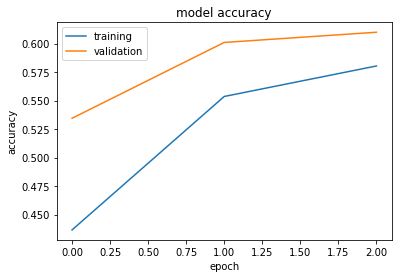

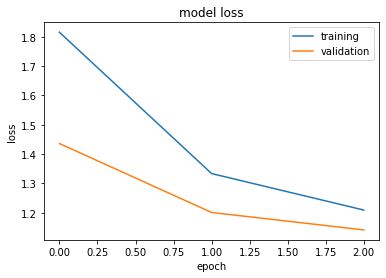

In [8]:
plot_training_history(history, model)

In [ ]:
assert (1==0)

# 5-Cross Validation

In [1]:
try:
    shuffle_arr
except NameError:
    import numpy as np
    import matplotlib.pyplot as plt
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout,Bidirectional,Conv1D, MaxPooling1D
    from keras.utils import to_categorical
    from keras.backend import clear_session
    from keras.optimizers import Adam
    import numpy as np
    import pickle
    import random
    from keras.layers.embeddings import Embedding
    from keras.preprocessing import sequence
    # fix random seed for reproducibility
    np.random.seed(21)

    try:
        list_of_data_arrays
    except NameError:
        with open(r"C:\Users\Sid\Desktop\bigpickle", "rb") as fp:   # Unpickling
            list_of_data_arrays=pickle.load(fp)    

    shuffle=list_of_data_arrays
    random.shuffle(shuffle)
    del(list_of_data_arrays)

    shuffle_arr=np.array(shuffle)[0:,0]
    shuffle_labels=np.array(shuffle)[0:,1]
    shuffle_obj_ids=np.array(shuffle)[0:,2]
    del(shuffle)

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
#Define some model parameters
num_folds = 5
validation_split = 0.1
max_length=max(map(len,shuffle_arr))
data_dim = 19
timesteps = max_length
num_classes = 15
num_epochs=3
batch_size=128

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
history_per_fold=[]

# Define inputs and targets
inputs = sequence.pad_sequences(shuffle_arr, maxlen=max_length)
targets = to_categorical(shuffle_labels, num_classes=15)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(inputs, targets):
    #Clear Keras history for no bias
    clear_session()
    #Create new Keras Sequential model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True,input_shape=(timesteps, data_dim)))
    model.add(LSTM(64))
    model.add(Dense(15, activation='softmax'))
    #Compile the model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history=model.fit(inputs[train], targets[train],batch_size=batch_size, epochs=num_epochs,verbose=True)
    # Generate generalization metrics
    history_per_fold.append(history)
    scores = model.evaluate(inputs[val], targets[val], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print(f"FOR {num_epochs} EPOCHS PER FOLD")
print('Scores per fold are:')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} % (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/3
6278/6278 [==============================] - 19s 3ms/step - loss: 1.8043 - accuracy: 0.4560
Epoch 2/3
6278/6278 [==============================] - 18s 3ms/step - loss: 1.3305 - accuracy: 0.5572
Epoch 3/3
6278/6278 [==============================] - 18s 3ms/step - loss: 1.2176 - accuracy: 0.5857
Score for fold 1: loss of 1.148380038388975; accuracy of 60.50955653190613%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/3
6278/6278 [==============================] - 17s 3ms/step - loss: 1.8088 - accuracy: 0.4431
Epoch 2/3
6278/6278 [==============================] - 19s 3ms/step - loss: 1.3523 - accuracy: 0.5524
Epoch 3/3
6278/6278 [==============================] - 19s 3ms/step - loss: 1.2085 - accuracy: 0.5957
Score for fold 2: loss of 1.1601448587551237; accuracy of 59.87260937690735%
-----------------------------------------

### Links:

https://keras.io/examples/imdb_lstm/

https://keras.io/examples/imdb_cnn_lstm/

https://keras.io/examples/imdb_bidirectional_lstm/

https://keras.io/examples/conv_lstm/

https://keras.io/regularizers/

https://keras.io/getting-started/sequential-model-guide/



conv and 2 lstms

adam, bs 4 64.28

2 lstms, 64, 64:
nadam - 62



batch size 4:
adam - 65 
adamax - 
nadam - 


3 lstms, 64,64,64:
adam - 57
nadam - 62